### Import libraries

In [60]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

### Settings of NN

In [91]:
# Set learning rate
learning_rate = 1

# Set bounds for the initialization of the random weights
weight_min = 0
weight_max = 1

# Set bounds for the initialization of the random bias
bias_min = 0
bias_max = 1

# Define the activation function
def sigmoid(drive):
    return 1/(1+np.exp(-drive))

# Define the derivative of the activation function
def sigmoidprime(drive):
    return np.exp(drive)/((np.exp(drive)+1)**2)


### Training data - Initialize input and expected output (labels)

In [63]:
# Because we are trying to learn our network as a logic gate 
# we can denote every possible input pair as follows
input_pairs = np.array([[0,0],[0,1],[1,0],[1,1]])

# Depending on which logic gate we are considering, 
# there will be different outputs or labels/targets for each input pair.
t_and = np.array([0,0,0,1])
t_or = np.array([0,1,1,1])
t_nand = np.array([1,1,1,0])
t_nor = np.array([1,0,0,0])
t_xor = np.array([0,1,1,0])

### Perceptron

In [85]:
class Perceptron:
    
    def __init__(self, input_units = None, activation = 0):
        # Initialize the input units so what feeds into the perceptron
        # this could be either an input pair if our perceptron is in the first hidden layer
        # or it could be other perceptrons if our perceptron is in any other layer
        self.input_units = input_units
        
        # Initialize random weights between weight_min and weight_max (uniformly)
        # one weight for each input unit
        try:
            # We try to initialize weights for the inputs, if there are no inputs
            # that means we are in the input layer and dont need any weights
            #self.weights = np.random.uniform(weight_min, weight_max, len(input_units))
            self.weights = np.random.randn(len(input_units))
        except TypeError:
            # no inputs means input_units = None
            # len(None) throws a TypeError which we except here
            # and just "initialize" the weights with an empty list
            self.weights = []
        
        # Initalize random bias between bias_min and bias_max (uniformly)
        # self.bias = np.random.uniform(bias_min, bias_max)
        self.bias = np.random.randn()
        
        # Initialize learning rate
        self.alpha = learning_rate
        
        # Initialize the activation
        self.activation = activation
        
        # Initialize the drive
        self.drive = 0
        
        
    def forward_step(self, input):
        # Perform a perceptron forward step.
        # 1. Calculate the drive. You can use @ as a matrix multiplication command.
        weighted_sum =  self.weights @ input + self.bias
        
        # 2. Denote the drive of the perceptron
        weighted_sum =  self.weights @ input + self.bias
        self.drive = weighted_sum
        
        # 3. Denote the activation of the perceptron
        self.activation = sigmoid(weighted_sum)
        
        # 4. Return the activation
        return self.activation
    
    
    def update(self, delta):
        # delta is the error vector of the next layer
        # delta * activation gives us the weight update
        # the activation can be taken from the perceptrons of the previous layer
        # if we reached the 2nd layer in the backpropagation then the previous layer
        # will be the input layer
        weight_update = delta * np.array([input_unit.activation for input_unit in self.input_units])
        
        # we update our weights according to our learning rate
        self.weights -= self.alpha * weight_update
        
        # we also update the bias
        bias_update = delta * 1
        self.bias -= self.alpha * bias_update
        
    def set_input(self, input):
        self.activation = input
        
        
        

### Multi-Layer Perceptron

In [86]:
class MLP:
    
    def __init__(self, shape = [1,1,1]):
        self.shape = shape
        # The shape determines the number of input, hidden and output neurons
        # [Perceptrons() for i in range(shape[0])] allows us to initialize as many Perceptrons 
        # as we indicated in the shape
        
        # We model input layer units as perceptrons with no input units 
        # but only an activation, which denotes their value, so the input of the MLP
        self.input_layer = [Perceptron() for i in range(shape[0])]
        
        # The input units of the hidden layer are the units of the input layer
        self.hidden_layer = [Perceptron(input_units = self.input_layer) for h in range(shape[1])]
        
        # The input units of the output layer are the units of the hidden layer
        self.output_layer = [Perceptron(input_units = self.hidden_layer) for o in range(shape[2])]
       
    
    def forward_step(self, input):
        # Input is one of our input pairs [[0,0],[0,1],[1,0],[1,1]]
        # This input has to be propergated forward through the MLP
        
        # Initialize the values of the input layer (activation) with the according input
        for input_unit, input_value in zip(self.input_layer, input):
            input_unit.set_input(input_value)
            
        # Calculate the activations of the hidden layer based on the input
        # the input is converted into a numpy array to get acces to the dot product function
        for hidden_unit in self.hidden_layer:
            hidden_unit.forward_step(np.array(input))
            
        # access the activation for each unit of the hidden layer
        hidden_layer_activations = [hidden_unit.activation for hidden_unit in self.hidden_layer]    
        
        # Calculate the activations of the output layer based on the hidden layer
        for output_unit in self.output_layer:
            # pass the activations to the output unit
            output_unit.forward_step(hidden_layer_activations)
        
        
    def backprop_step(self, label):
        # Calculate the error term for each unit of the ouput layer
        # in our case that would just be one
        delta_o = []
        for output_unit in self.output_layer:
            delta_o.append(-(label - output_unit.activation) * sigmoidprime(output_unit.drive))
            
        # Now we can update the weights and bias of our ouput units
        for output_unit, delta in zip(self.output_layer, delta_o):
            output_unit.update(delta)
            
        # Next up we calculate the error terms of the hidden layer
        delta_h = []
        for index, hidden_unit in enumerate(self.hidden_layer):
            delta_h.append((delta_o[0] * self.output_layer[0].weights[index]) * sigmoidprime(hidden_unit.drive))
            
        # And again we update the weights and bias according to the error terms
        for hidden_unit, delta in zip(self.hidden_layer, delta_h):
            hidden_unit.update(delta)
                
        
            
        

### Training a MLP on AND gate

In [94]:
# Create a Mulit-Layer Perceptron with
# 1 input layer consisting of 2 input units
# 1 hidden layer consisting of 4 hidden units
# 1 output layer consisting of 1 output unit
my_MLP = MLP([2,4,1])

# Choose logic gate
target = t_xor

# Initialize lists to store steps and performance.
steps = []
accuracies = []

# Now we train the MLP for 1000 epochs and track the steps and accuracy
for i in range(4000):
    steps.append(i)
    
    # 1. Draw a random sample from the input pairs and the corresponding targets.
    index = np.random.randint(len(input_pairs))
    sample = input_pairs[index]
    label = target[index]
    
    # 2. Perform a forward step
    my_MLP.forward_step(sample)
    
    # 3. Perform a backprop-step
    my_MLP.backprop_step(label)
    
    # 4. Calculate the performance over all four possible inputs.
    accuracy_sum = 0
    for k in range(len(input_pairs)):
        # forward the input pair through the MLP
        my_MLP.forward_step(input_pairs[k])
        output = my_MLP.output_layer[0].activation
        
        # if the MLP's prediction is closer than 0.5 to the actual target
        # it counts as a correct classification and
        accuracy_sum += int(abs(output - target[k]) < 0.5)
    
    # we divide through all the training examples
    accuracy = accuracy_sum / 4                  
    accuracies.append(accuracy)   
    
    
    

### Visualize training process

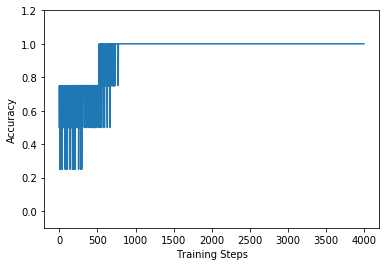

In [95]:
plt.figure()
plt.plot(steps, accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.2])
plt.show()